In [0]:
# Import libs
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import os 
import sys
import random
from tqdm import tqdm

from keras.models import Model, load_model
from keras.layers import Input, Dense, MaxPooling2D, UpSampling2D, Dropout
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import optimizers

import tensorflow as tf

In [0]:
np.random.seed = 42

# Set operating parameters
TRAIN_IMG_PATH = 'training_validation_Hair_Skin_Masks/training_hair_skin/images'
VALID_IMG_PATH = 'training_validation_Hair_Skin_Masks/validation_hair_skin/images'
TEST_IMG_PATH = 'testing_images/testing_images'
TRAIN_MASK_PATH = 'training_validation_Hair_Skin_Masks/training_hair_skin/masks'
VALID_MASK_PATH = 'training_validation_Hair_Skin_Masks/validation_hair_skin/masks'

IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3

In [0]:
# Get list of training and testing filenames
train_ids = next(os.walk(TRAIN_IMG_PATH))[2]
test_ids = next(os.walk(TEST_IMG_PATH))[2]
train_masks = next(os.walk(TRAIN_MASK_PATH))[2]
valid_ids=next(os.walk(VALID_IMG_PATH))[2]
valid_masks=next(os.walk(VALID_MASK_PATH))[2]

#Sort the list of training and testing ids
train_ids=sorted(train_ids, key=lambda s: int(s.split('_')[2].split('.')[0]))
train_masks=sorted(train_masks, key=lambda s: int(s.split('_')[2].split('.')[0]))
test_ids=sorted(test_ids, key=lambda s: int(s.split('_')[2].split('.')[0]))
valid_ids=sorted(valid_ids, key=lambda s: int(s.split('_')[2].split('.')[0]))
valid_masks=sorted(valid_masks, key=lambda s: int(s.split('_')[2].split('.')[0]))

In [0]:
# Get and resize training images
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting and resizing train images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_IMG_PATH + '/'+ id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS), mode='constant', preserve_range=True)
    X_train[n] = img
    # print(X_train[n]);

# Get and resize training mask images
Y_train = np.zeros((len(train_masks), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
print('Getting and resizing training masks ... ')
# sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_masks), total=len(train_masks)):
    path = TRAIN_MASK_PATH + '/' + id_
    mask = imread(path)
    mask[:,:,1]=0
    mask[:,:,2]=0
    # mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS))
    Y_train[n] = mask
    
    
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_IMG_PATH + '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS), mode='constant', preserve_range=True)
    X_test[n] = img
    
    
#encoding function to seperate the hair from the skin and background in the training masks 
def encode(masks):
  train_labels = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,1), dtype=np.bool)
  count=0
  for image in range(0,len(masks)):
    mask=np.zeros((IMG_HEIGHT,IMG_WIDTH,1), dtype=np.bool)
    for row in range(0,len(masks[image])):
      for pixel in range(0,len(masks[image][row])):
        currentpixel=masks[image][row][pixel]
        if (currentpixel[0] == 1):
          mask[row][pixel]=1
          continue
        else: 
          mask[row][pixel]=0
          continue
    train_labels[count]= mask
    count+=1
  return train_labels

train_labels=encode(Y_train)
# valid_labels=encode(y_valid)
print("Done")



Getting and resizing train images ... 


  1%|          | 13/1500 [00:00<00:11, 126.94it/s]

Getting and resizing training masks ... 


100%|██████████| 1500/1500 [00:15<00:00, 97.14it/s]


Getting and resizing test images ... 


100%|██████████| 927/927 [00:08<00:00, 112.38it/s]


Done


In [0]:
#printing the length of train labels
print(len(train_labels))


1500


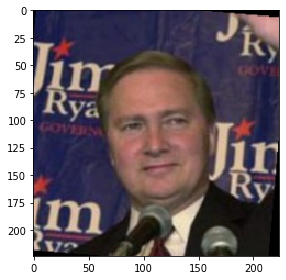

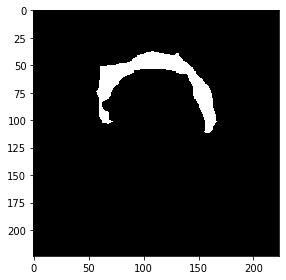

In [0]:
# Perform a sanity check on some random training samples
ix=random.randint(0,len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(train_labels[ix]))
plt.show()

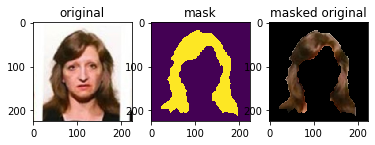

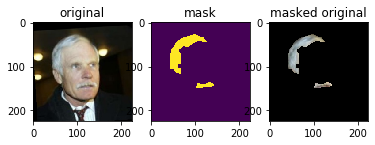

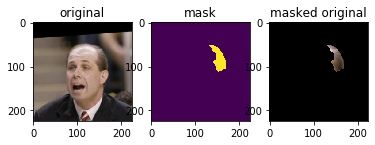

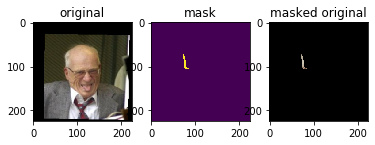

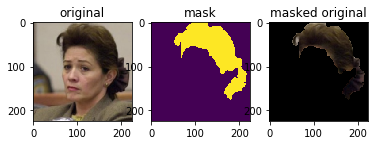

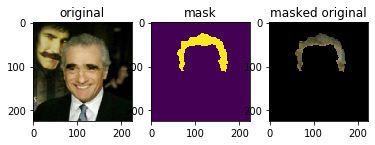

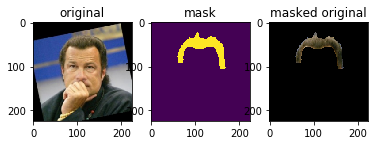

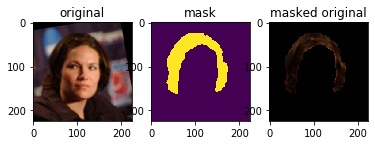

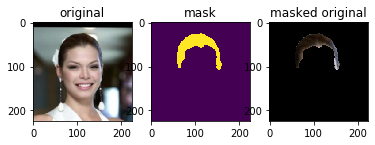

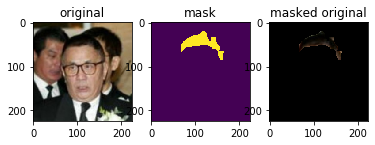

In [0]:
# Check if training and mask data looks all right
for ix in np.arange(10):
    # Mask should be a 2D array for plot
    mask = np.squeeze(train_labels[ix])

    # Create a masked image
    masked = np.copy(X_train[ix]) * train_labels[ix]
    
    # Display original, mask, and masked images side-by-side
    f, (ax0, ax1, ax2) = plt.subplots(1, 3)
    ax0.set_title('original')
    ax0.imshow(X_train[ix])
    ax1.set_title('mask')
    ax1.imshow(mask)
    ax2.set_title('masked original')
    ax2.imshow(masked)
    plt.show()

In [0]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
model.summary()

# Fit model
# earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-hair-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, train_labels, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 224, 224, 16) 448         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 224, 224, 16) 0           conv2d_39[0][0]                  
____________________________________________________________________________________________

In [0]:
# Predict on train, val and test
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

927/927 [==============================] - 1s 2ms/step


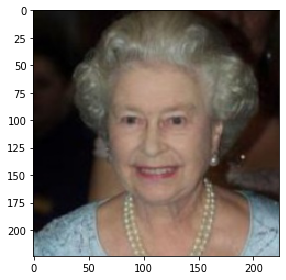

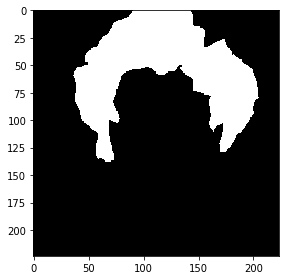

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


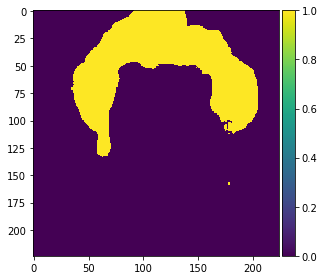

In [0]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(train_labels[int(train_labels.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [0]:
!pip3 install scipy==1.1.0.

In [0]:
from skimage.transform import resize
from skimage.io import imread
from scipy.misc.pilutil import imread, imresize, imsave
%matplotlib inline  


# choose a local (colab) directory to store the data.
local_download_path = '/content/drive/My Drive/Final Project/Testing_results/Testing mask'
path='/content/drive/My Drive/Final Project/Testing_results'
try:
  os.makedirs(local_download_path)
except: pass



# Save masks to output folder
test_ids_ = list(map(lambda x:x.replace('img','mask'),test_ids)) # Convenience, rename the file name list

# Properly shape all test-prediction masks and save them
for i in np.arange(len(preds_test_t)):
    mask_ = np.squeeze(preds_test_t[i])
    mask_ = np.array(mask_*255, dtype='uint8')
    mask_ = imresize(mask_, size=sizes_test[i]) # upsampled masks
    fname = os.path.join(local_download_path, test_ids_[i])
    imsave(fname, mask_)

# (* update) the input_path using your folder path
input_path = "/content/drive/My Drive/Final Project/Testing_results/Testing mask"

# get a sorted list of all mask filenames in the folder
masks = [f for f in os.listdir(input_path) if f.endswith('.jpg')]
masks = sorted(masks, key=lambda s:int(s.split('_')[2].split('.')[0]))

def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

# encode all masks
encodings = []
for file in masks:
    mask = imread(os.path.join(input_path, file))
    #img_size =10
    #mask = resize(mask, (img_size, img_size), mode='constant', preserve_range=True)
    mask = np.array(mask, dtype=np.uint8)
    mask = np.round(mask/255)
    encodings.append(rle_encoding(mask))


# (** update) the path where to save the submission csv file
sub = pd.DataFrame()
sub['ImageId'] = pd.Series(masks).apply(lambda x: os.path.splitext(x)[0])
sub['EncodedPixels'] = pd.Series(encodings).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(os.path.join(path, 'Main_code.csv'), index=False)
print("Complete...!!!!!!")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Complete...!!!!!!
